# Linear Models
## Dream Team - ORIE 4741 Project

In [1]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random, Lasso, MLBase
# LassoPlot is not working with the other updated packages

In [2]:
include("../plot_pred.jl")

plot_pred_true (generic function with 2 methods)

Load data from CSV.

In [100]:
df = CSV.read("../data collection/weekly_ff_elo.csv", DataFrame)
# df = DataFrame(load("weekly_ff.csv"))

feature_names = names(df)
for i in 1:58
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Int64
6	PassingTD			Int64
7	Int			Int64
8	PassingAtt			Int64
9	Cmp			Int64
10	RushingAtt			Int64
11	RushingYds			Int64
12	RushingTD			Int64
13	Rec			Int64
14	Tgt			Int64
15	ReceivingYds			Int64
16	ReceivingTD			Int64
17	FL			Int64
18	PPRFantasyPoints			Float64
19	StandardFantasyPoints			Float64
20	HalfPPRFantasyPoints			Float64
21	type			String
22	game_id			Int64
23	team2			String
24	season			Int64
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_cum			Float64
36	Tgt_cum			Float64
37	ReceivingYds_cum			Float64
38	ReceivingTD_cum			Float64
39	FL_cum			Float64
40	team1_score_cum			Float64
41	team2_score_cum			Float64
42	PassingYds_prev			Int64
43	PassingTD_prev			Int64
44	Int_prev			Int64
45	PassingAt

Train/test split with proportion of training data = 0.8

In [101]:
Random.seed!(0)

df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = target[1:ntrain, :StandardFantasyPoints]
test_std = target[ntrain:end, :StandardFantasyPoints]

train_ppr = target[1:ntrain, :PPRFantasyPoints]
test_ppr = target[ntrain:end, :PPRFantasyPoints]

train_half = target[1:ntrain, :HalfPPRFantasyPoints]
test_half = target[ntrain:end, :HalfPPRFantasyPoints]

# let's take a look
train_x

Size of dataset: 51622


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,16,Chester Taylor,RB,MIN,0,0,0,0
2,16,Nate Burleson,WR,DET,0,0,0,0
3,14,Kyle Orton,QB,DEN,166,0,3,41
4,3,Kellen Winslow,TE,TAM,0,0,0,0
5,8,Joe Flacco,QB,BAL,319,1,0,37
6,12,Aaron Hernandez,TE,NWE,0,0,0,0
7,12,Sony Michel,RB,NWE,0,0,0,0
8,11,Chris Harper,WR,SFO,0,0,0,0
9,13,Tom Brady,QB,NWE,352,2,2,29


Create a real-valued subset.

In [102]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev,
    :elo1_pre,
    :elo2_pre
]

train_real = train_x[:, labels_real]
test_real = test_x[:, labels_real];

Convert the categorical labels into one-hot encoded data. This is for the team of the player (team1) and the team of the opponent (team2) as well as the position. 

In [103]:
cat_labels = [
  # :team1,
  # :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);

In [104]:
# Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0);
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals), NaN=>0);
# Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0);
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals), NaN=>0);

In [134]:
# export 
train_df = DataFrame(hcat(Xtrain, train_std, train_ppr, train_half));
test_df = DataFrame(hcat(Xtest, test_std, test_ppr, test_half));
# CSV.write("$(pwd())\\train_impute.csv", train_df);
# CSV.write("$(pwd())\\test_impute.csv", test_df)

"C:\\Users\\darre\\Documents\\_cornell 20-21\\orie 4741\\dream-team\\base models\\test_impute.csv"

In [106]:
train_df

,x1,x2,x3,x4,x5,x6,x7,x8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,5.64286,21.2143,0.0714286
2,0.0,0.0,0.0,0.0,0.0,0.416667,4.08333,0.0
3,290.583,1.66667,0.5,38.0833,22.8333,1.66667,7.75,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,265.286,1.28571,1.14286,41.0,25.7143,1.0,0.571429,0.285714
6,0.0,0.0,0.0,0.0,0.0,0.222222,3.44444,0.0
7,0.0,0.0,0.0,0.0,0.0,15.1429,64.7143,0.571429
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,298.727,1.81818,0.727273,39.0,25.6364,1.90909,4.09091,0.0909091


In [55]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

# OLS
## OLS by hand

In [108]:
w = Xtrain \ train_std
train_pred = sum(w'.*Xtrain, dims = 2)
test_pred = sum(w'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

32.87950009235571

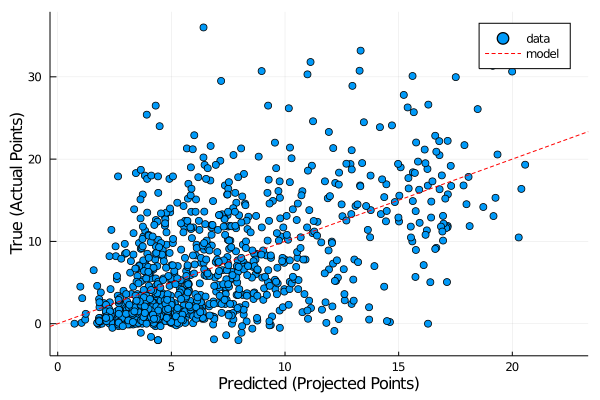

In [109]:
plot_pred_true(test_pred, test_std)

## OLS with GLM package
Use GLM package for OLS

In [110]:
Xtrain_glm = replace(hcat(convert(Matrix, train_real), train_cat_vals), NaN=>0)

41298×37 Array{Float64,2}:
   0.0    0.0       0.0        0.0     …  1419.91  1.0  0.0  0.0  0.0  0.0
   0.0    0.0       0.0        0.0        1508.48  0.0  1.0  0.0  0.0  0.0
 290.583  1.66667   0.5       38.0833     1334.88  0.0  0.0  1.0  0.0  0.0
   0.0    0.0       0.0        0.0        1569.39  0.0  0.0  0.0  1.0  0.0
 265.286  1.28571   1.14286   41.0        1449.06  0.0  0.0  1.0  0.0  0.0
   0.0    0.0       0.0        0.0     …  1328.26  0.0  0.0  0.0  1.0  0.0
   0.0    0.0       0.0        0.0        1356.26  1.0  0.0  0.0  0.0  0.0
   0.0    0.0       0.0        0.0        1654.3   0.0  1.0  0.0  0.0  0.0
 298.727  1.81818   0.727273  39.0        1498.59  0.0  0.0  1.0  0.0  0.0
   0.0    0.0       0.0        0.0        1623.89  0.0  1.0  0.0  0.0  0.0
 176.333  0.666667  0.333333  27.0     …  1364.78  0.0  0.0  1.0  0.0  0.0
   0.0    0.0       0.0        0.0        1507.64  0.0  0.0  0.0  1.0  0.0
   0.0    0.0       0.0        0.0        1663.06  1.0  0.0  0.0  0.0  0.

Use $\texttt{allowrankdeficient = true}$ to analytically solve some of the issues with multicollinearity.

In [111]:
m2 = lm(Xtrain, train_std, true)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,CholeskyPivoted{Float64,Array{Float64,2}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────────────
            Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────
x1    0.0237021    0.00430999    5.50    <1e-7    0.0152544    0.0321497
x2    1.09223      0.218502      5.00    <1e-6    0.663961     1.5205
x3   -0.160533     0.220099     -0.73    0.4658  -0.591932     0.270866
x4   -0.201312     0.044575     -4.52    <1e-5   -0.28868     -0.113944
x5    0.326165     0.0736378     4.43    <1e-5    0.181833     0.470497
x6    0.0863998    0.0297955     2.90    0.0037   0.028        0.1448
x7    0.0527602    0.00611575    8.63    <1e-17   0.0407732    0.0647472
x8    1.29506      0.24554       5.27    <1e-6    0.813794     1.77632
x9   -0.249329     0.0776605    -3.21    0.0013  -0.401546    -0.0971132
x10  

In [112]:
Xtest_glm = replace(hcat(convert(Matrix, test_real), test_cat_vals), NaN=>0)
pred_m2_test = predict(m2, Xtest)
test_MSE = MSE(test_std, pred_m2_test)

32.87950009235574

Generic OLS with the first matrix (that has 198 rows) shows that some columns may be multicollinear, so we should consider how to resolve this multicollinearity. We can create a new matrix that takes out the multicollinear columns.

In [17]:
Xtrain_glm2 = hcat(Xtrain_glm[:,1:93], Xtrain_glm[:, 95:128], Xtrain_glm[:, 130:184]);

That allows us to calculate OLS with the typical algorithm.

In [113]:
m3 = lm(Xtrain, train_std);

In [114]:
pred_m3 = predict(m3, Xtrain);

In [115]:
# Xtest_glm2 = hcat(Xtest_glm[:,1:93], Xtest_glm[:, 95:128], Xtest_glm[:, 130:184])
pred_m3_test = predict(m3, Xtest)
test_MSE = MSE(test_std, pred_m3_test)

32.87950009235574

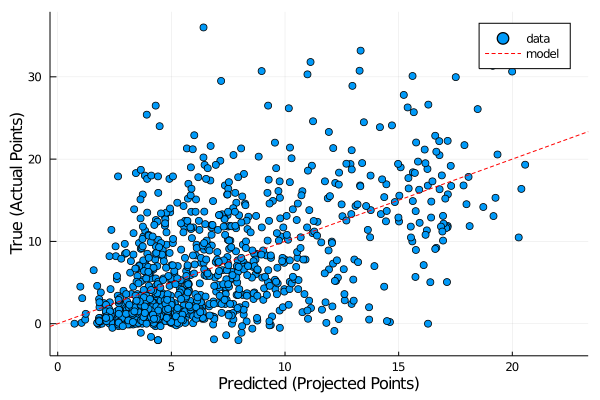

In [118]:
plot_pred_true(pred_m2_test, test_std)
# savefig("ols.png")

# Lasso Regression
## Lasso paths with Lasso.jl

In [120]:
m_lasso = fit(LassoPath, Xtrain, train_std, Normal())

LassoPath (83) solutions for 38 predictors in 6286 iterations):
───────────────────────────────────
               λ    pct_dev  ncoefs
───────────────────────────────────
 [1]  2.82658     0.0             0
 [2]  2.57547     0.027971        1
 [3]  2.34667     0.0511929       1
 [4]  2.1382      0.0704722       1
 [5]  1.94825     0.0864783       1
 [6]  1.77517     0.0997667       1
 [7]  1.61747     0.121716        2
 [8]  1.47378     0.139987        2
 [9]  1.34285     0.155156        2
[10]  1.22356     0.167878        3
[11]  1.11486     0.178471        3
[12]  1.01582     0.194874        5
[13]  0.925576    0.212596        6
[14]  0.84335     0.228057        7
[15]  0.76843     0.241043        7
[16]  0.700164    0.251829        7
[17]  0.637964    0.260779        7
[18]  0.581289    0.268213        7
[19]  0.529649    0.274385        8
[20]  0.482596    0.279517        9
[21]  0.439724    0.283868        9
[22]  0.40066     0.28748         9
[23]  0.365066    0.290498       11


In [121]:
pred_m_lasso_test = predict(m_lasso, Xtest)[:, 83]
test_MSE_lasso = MSE(test_std, pred_m_lasso_test)

32.87124429026499

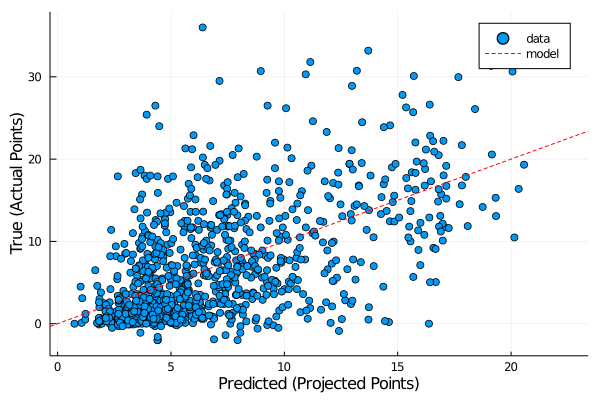

In [122]:
plot_pred_true(pred_m_lasso_test, test_std)
# savefig("lasso.png")

In [25]:
# plot(m_lasso; x = m_lasso[:, :logλ])

## Cross-validation procedure to select $\lambda$ for lasso regression

Train lasso model with 10-fold cross validation procedure.

In [82]:
# Xtrain = replace(hcat(convert(Matrix, train_real)), NaN=>0)
# Xtest = replace(hcat(convert(Matrix, test_real)), NaN=>0)

10550×30 Array{Float64,2}:
 224.286  1.0      0.571429  35.7143  …   1.0   -4.0  0.0  0.0  17.0  16.0
   0.0    0.0      0.0        0.0         6.0   34.0  0.0  0.0  13.0  27.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0  41.0  21.0
   0.0    0.0      0.0        0.0         8.0   20.0  0.0  0.0  10.0  40.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0   0.0   0.0
   0.0    0.0      0.0        0.0     …   5.0   37.0  0.0  0.0  27.0  37.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0   0.0   0.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0  54.0  51.0
 189.0    1.0      1.0       33.0         0.0    0.0  0.0  0.0  16.0  36.0
   0.0    0.0      0.0        0.0         2.0    2.0  0.0  0.0  10.0  34.0
   0.0    0.0      0.0        0.0     …   5.0   33.0  0.0  1.0  20.0  19.0
 215.333  1.66667  0.333333  31.6667      0.0    0.0  0.0  0.0  31.0  21.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0   0.0   0.

In [123]:
Random.seed!(0)
lasso_cv = fit(LassoModel, Xtrain, train_std; select = MinCVmse(Kfold(41298, 5)), standardize = false, intercept = false);

Although we have 188 features in this feature matrix, the Lasso cross-validation generates a coefficient matrix that only uses 30 coefficients. 

In [124]:
pred_lasso_cv = predict(lasso_cv, Xtest)

10325-element Array{Float64,1}:
  5.019723211220036
  4.158836077113278
  4.121458674841451
  6.190442529502275
  5.499432840042443
  3.0685896796767826
  4.433734909384828
  4.522258212736537
  4.270663543953017
  5.994378269024101
  8.37648133121469
 16.8625326615754
  7.3516496888432314
  ⋮
 10.316645595899796
  6.950500976961777
  5.541439778069032
  2.7736750271898134
  4.042255053791519
  4.343522951256585
 13.341570051570262
  3.583871590043267
 11.510428679929735
  3.0016882185561267
  3.7753846700276195
  8.108238131442986

In [126]:
lasso_cv_ppr = fit(LassoModel, Xtrain, train_ppr; select = MinCVmse(Kfold(41298, 5)), standardize = false, intercept = false);
pred_lasso_cv_ppr = predict(lasso_cv_ppr, Xtest)
lasso_cv_half = fit(LassoModel, Xtrain, train_half; select = MinCVmse(Kfold(41298, 5)), standardize = false, intercept = false);
pred_lasso_cv_half = predict(lasso_cv_half, Xtest);

In [127]:
test_MSE_lasso_cv = MSE(test_std, pred_lasso_cv)
test_MSE_lasso_ppr = MSE(test_ppr, pred_lasso_cv_ppr)
test_MSE_lasso_half = MSE(test_half, pred_lasso_cv_half);

@show test_MSE_lasso_cv;
@show test_MSE_lasso_ppr;
@show test_MSE_lasso_half;

test_MSE_lasso_cv = 33.70873269560487
test_MSE_lasso_ppr = 46.433728854829695
test_MSE_lasso_half = 39.22554685360731


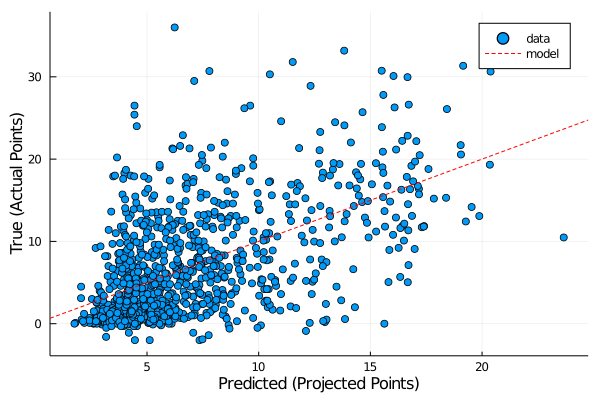

In [128]:
plot_pred_true(pred_lasso_cv, test_std)

Create dataframe of all data.

In [129]:
Xtrain_df = DataFrame(Xtrain)
Xtrain_df.Y = train_std
Xtrain_df;

## Export

Export linear predictions as a .csv for use in projections.

In [130]:
test_pred_all = DataFrame(std_lasso = pred_lasso_cv, ppr_lasso = pred_lasso_cv_ppr, half_lasso = pred_lasso_cv_half)
# CSV.write("$(pwd())\\test_pred.csv", test_pred_all)

"C:\\Users\\darre\\Documents\\_cornell 20-21\\orie 4741\\dream-team\\base models\\test_pred.csv"

In [131]:
df_x = df[:, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
df_real = df_x[:, labels_real]
df_cats = hcat([onehot(df_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
df_matrix = replace(hcat(convert(Matrix, df_real), df_cats), NaN=>0)
# df_matrix = replace(convert(Matrix, df_real), NaN => 0)
points_pred_lm = predict(m2, df_matrix)
points_pred_lasso = predict(lasso_cv, df_matrix);

In [132]:
df_points = df[:, 1:4]
df_points.std_lm = points_pred_lm
df_points.std_lasso = points_pred_lasso
df_points.season = df[:, 24]
df_points

,week,Player,Pos,team1,std_lm,std_lasso,season
,Int64,String,String,String,Float64,Float64,Int64
1,16,Chester Taylor,RB,MIN,6.13419,6.61607,2009
2,16,Nate Burleson,WR,DET,6.57976,6.10859,2010
3,14,Kyle Orton,QB,DEN,15.3975,15.9198,2010
4,3,Kellen Winslow,TE,TAM,6.79901,6.73617,2011
5,8,Joe Flacco,QB,BAL,14.5658,14.8761,2015
6,12,Aaron Hernandez,TE,NWE,6.28358,7.07166,2010
7,12,Sony Michel,RB,NWE,9.22869,9.13102,2018
8,11,Chris Harper,WR,SFO,3.23547,3.20593,2016
9,13,Tom Brady,QB,NWE,16.1705,16.9653,2009


In [133]:
# CSV.write("..\\projections_2019\\points_proj.csv", df_points)

"..\\projections_2019\\points_proj.csv"